---
title: Validating EpigenomeXcan against RatXcan
author: Sabrina Mi
date: 8/8/2024
description: Plots of Fast Enformer vs PrediXcan gene expression prediction and Fast Enformer vs Observed point to Fast Enformer adequately predicting variation across individuals for the goal of identifying significant genes. Specifically, Fast Enformer and PrediXcan tend to correlate strongly (positive and negative) when compared across individuals for a fixed gene.
---

EpigenomeXcan consists of two steps: 1. Fast Enformer prediction for gene expression and 2. Calculate Gene-Trait association under a linear mixed effects model. 

We predicted gene expression in brain tissues using both Fast Enformer and PrediXcan methods.

**August 9 Note**: I have not started implemented mixed effects model, so I only have comparisons for Fast Enformer gene expression predictions against RatXcan.

### Read in Predicted Expression

Fast Enformer predictions were computed in this [blog post](https://sabrina-dl.hakyimlab.org/posts/2024-07-10-br-epigenomexcan-test/)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("pastel")
predictions_dir = '/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders'


The output files from Fast Enformer are split by chromosome, so the code below combines them into a single file.

In [ ]:
#| code-fold: true
predictions_by_chrom = []
for N in range(1,21):
    df = pd.read_csv(f'{predictions_dir}/chr{N}_CAGE_brain__predict.txt', index_col=0)
    predictions_by_chrom.append(df)
CAGE_predictions = pd.concat(predictions_by_chrom, axis=1)
CAGE_predictions.to_csv(f'{predictions_dir}/Br_all_genes_by_tissue/Br_CAGE_brain__predict.txt')

In [3]:
CAGE_predictions = pd.read_csv(f'{predictions_dir}/Br_all_genes_by_tissue/Br_CAGE_brain__predict.txt', index_col=0)

### Run PrediXcan

I ran locally, then copied to polaris.

```
cd /Users/sabrinami/ratxcan-tutorial

conda activate imlabtools

python MetaXcan/software/Predict.py \
--model_db_path models/AC-filtered.db \
--model_db_snp_key rsid \
--vcf_genotypes data/genotype/Brain.rn7.vcf.gz \
--vcf_mode genotyped \
--liftover data/liftover/rn7ToRn6.over.chain.gz \
--on_the_fly_mapping METADATA "{}_{}_{}_{}" \
--prediction_output output/AC-filtered-Br__predict.txt  \
--prediction_summary_output output/AC-filtered-Br__summary.txt \
--throw
```


## Comparing Predicted Expression Results from Fast Enformer and PrediXcan

We have two dataframes with individuals as rows and genes as columns. We compute correlation across individuals (fixing a gene) as well as correlation across genes (fixing an individual) and plot their distributions

In [27]:
AC_predictions = pd.read_csv('/home/s1mi/PrediXcan/Br/AC-filtered-Br__predict.txt', sep = '\t', index_col = 'IID').drop('FID', axis=1)
gene_list = (AC_predictions.columns).intersection(CAGE_predictions.columns)
individuals = list(AC_predictions.index)
filtered_AC_predictions = AC_predictions.reindex(columns = gene_list)
filtered_CAGE_predictions = CAGE_predictions.reindex(index = individuals, columns = gene_list)

### Correlations across Individuals

**How well does Fast Enformer approximate PrediXcan when predicting variation across individuals?**

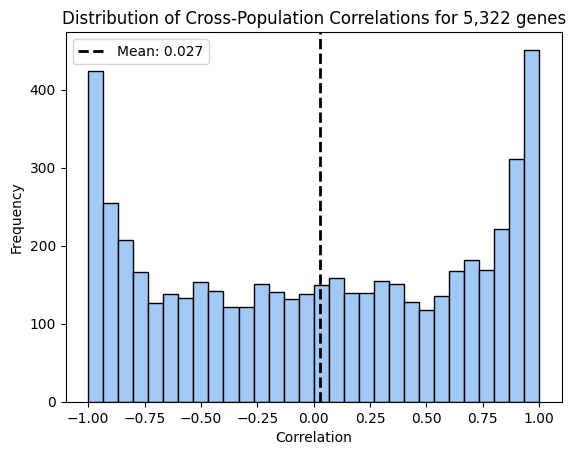

In [39]:
correlations_across_individuals = filtered_AC_predictions.corrwith(filtered_CAGE_predictions, axis=0)
#plt.figure(figsize=(10, 6))
plt.hist(correlations_across_individuals, bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of Cross-Population Correlations for 5,322 genes')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
mean = np.mean(correlations_across_individuals)
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
plt.show()

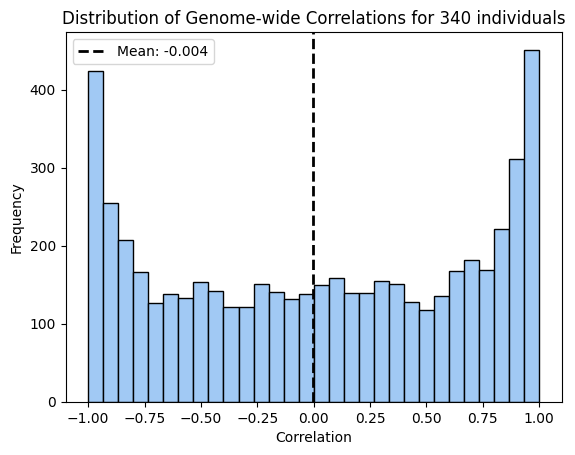

In [40]:
correlations_across_genes = filtered_AC_predictions.corrwith(filtered_CAGE_predictions, axis=1)
#plt.figure(figsize=(10, 6))
plt.hist(correlations_across_individuals, bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of Genome-wide Correlations for 340 individuals')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
mean = np.mean(correlations_across_genes)
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
plt.show()

### Correlations across Genes

This is less relevant, since our focus is to identify significant gene-trait associations by phenotype variation across individuals is regressed on gene expression variation across indviduals. However, we still check that Fast Enformer can predict variation across the genome for each individual.


## Comparing Fast Enformer Predicted Expression to Observed

### Correlation across individuals

In [45]:
gene_expr_bed = "/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed"
obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id').transpose()
filtered_observed = obs_gene_expr.reindex(index = individuals, columns = gene_list)


/tmp/ipykernel_2917084/641794222.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id').transpose()


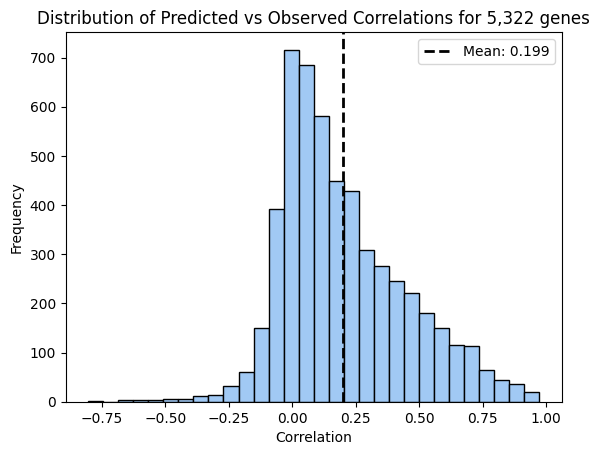

In [48]:
correlations_across_individuals = filtered_AC_predictions.corrwith(filtered_observed, axis=0)
#plt.figure(figsize=(10, 6))
plt.hist(correlations_across_individuals, bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of Predicted vs Observed Correlations for 5,322 genes')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
mean = np.mean(correlations_across_individuals)
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
plt.show()